# Geometry computations Example 2: Movement hull statistics in grid-system

In this notebook, we:

* (1) Represent animals as polygonal shapes created from pose-estimation data, and 
* (1) Divide the experimental arena into distinct geometrical regions, and
* (2) Compute and visualize the time the animal spends in each region of the arena.

This analysis can be used to study spatial preferences in the experimental arena. This analysis is based on the location of a entire animal hull. To perform the analysis using pose-estimated key-points, see [THIS](https://simba-uw-tf-dev.readthedocs.io/en/latest/nb/geometry_example_1.html) notebook. 

In [1]:
import time
import numpy as np
import os
from simba.mixins.geometry_mixin import GeometryMixin
from simba.mixins.config_reader import ConfigReader
import cv2
from simba.utils.read_write import read_df
from simba.mixins.plotting_mixin import PlottingMixin
from simba.mixins.image_mixin import ImageMixin
from simba.utils.read_write import read_frm_of_video
import matplotlib.pyplot as plt
import matplotlib 
dpi = matplotlib.rcParams['figure.dpi']

In [2]:
# DEFINE PROJECT AND VIDEO NAME
PROJECT_PATH = r'/Users/simon/Desktop/envs/troubleshooting/Rat_NOR/project_folder/project_config.ini'
VIDEO_PATH = r'/Users/simon/Desktop/envs/troubleshooting/Rat_NOR/project_folder/videos/2022-06-20_NOB_DOT_4.mp4'
VIDEO_NAME = '2022-06-20_NOB_DOT_4'

In [3]:
# READ IN THE DATA, VIDEO SIZE, FPS, AND PIXEL CONVERSION FACTOR.
config = ConfigReader(config_path=PROJECT_PATH, create_logger=False)
video_info, px_per_mm, fps = config.read_video_info(video_name=VIDEO_NAME)
width, height = int(video_info['Resolution_width'].values[0]), int(video_info['Resolution_height'].values[0])
data_path = os.path.join(config.outlier_corrected_dir, VIDEO_NAME + f'.{config.file_type}')
data = read_df(file_path=data_path, file_type=config.file_type)
bps = [x for x in config.bp_headers if not x.endswith('_p')]
bps = [x for x in bps if not 'Tail_end' in x] #WE REMOVE THE TAIL END FROM THE TRACKED BODY-PARTS AS ITS NOT VERY ACCURATE
data = data[bps].values.astype(int)

In [4]:
# WE RESHAPE THE POSE-ESTIMATION TO A 3D ARRAY, AND CREATE POLYGONS REPRESENTING THE ANIMALS FROM THE POSE-ESTIMATED DATA
# WE ALSO ISE A "SAFTY ZONE" BY BUFFERING THE POLYGONS WITH A 5CM AREA (parallel_offset=50). 
data = data.reshape(len(data), int(data.shape[1] / 2), 2)
shapes = GeometryMixin().multiframe_bodyparts_to_polygon(data=data, parallel_offset=50, pixels_per_mm=px_per_mm)

SIMBA COMPLETE: Polygons complete. (elapsed time: 2.7999s) 	complete


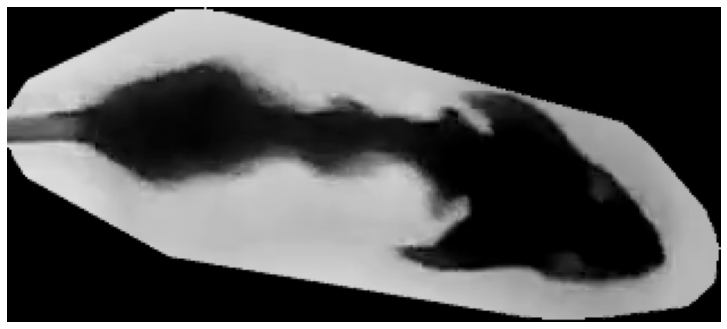

In [5]:
# AS A SANITY CHECK, WE VISUALIZE ONE OF THE POLYGONS, IN IMAGE 4, TO SEE IF WE ACCURATLY SLICE OUT THE ANIMAL AND THAT THE POLYGONS
# REPRESENT THE ANIMAL.
frame_idx = 4
animal_img = read_frm_of_video(video_path=VIDEO_PATH, frame_index=frame_idx)
animal_img = ImageMixin().slice_shapes_in_img(img=animal_img, geometries=[shapes[frame_idx]])[0]

animl_height, animal_width, _ = animal_img.shape
figsize = (animal_width / float(dpi)) * 3, (animl_height / float(dpi)) * 3

plt.figure(figsize=figsize)
plt.axis('off')
plt.imshow(animal_img)
plt.show()

In [6]:
# WE CREATE A SQUARE GEOMETRY GRID WHICH IS 5 BY 5 LARGE TO COVER THE EXPERIMENTAL ARENA
GRID_SIZE = (5, 5)
grid, aspect_ratio = GeometryMixin().bucket_img_into_grid_square(img_size=(width, height), bucket_grid_size=GRID_SIZE, px_per_mm=px_per_mm)

SIMBA COMPLETE: Bucket image into grid squares complete (elapsed time: 0.0005s) 	complete


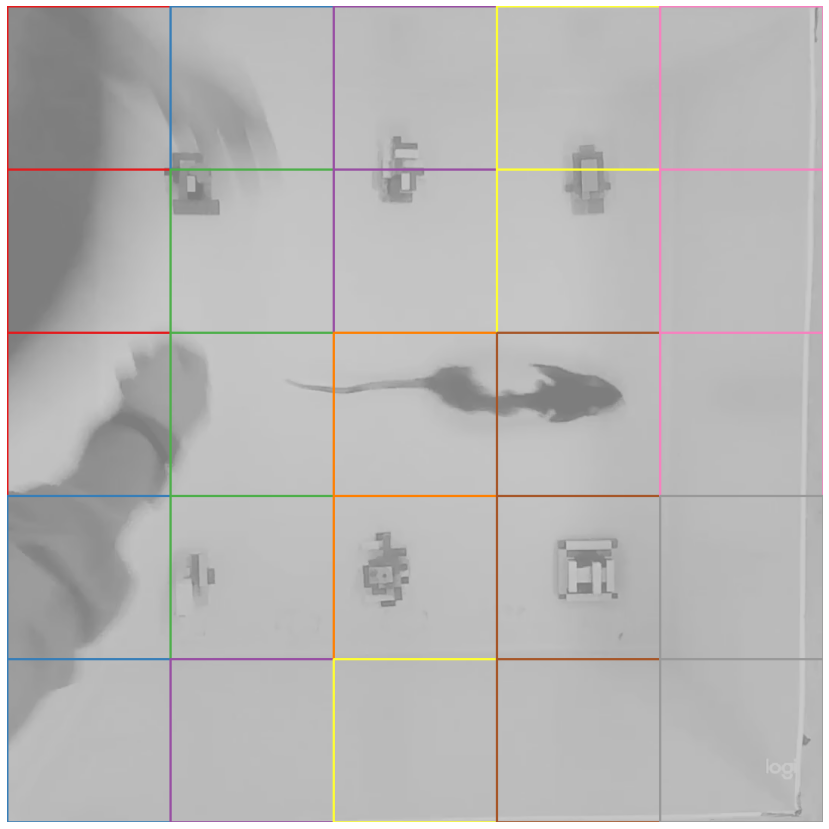

In [7]:
# WE VISUALIZE THE GRID AS A SANITY CHECK 
video_path = r'/Users/simon/Desktop/envs/troubleshooting/Rat_NOR/project_folder/videos/2022-06-20_NOB_DOT_4.mp4'
video_frm = read_frm_of_video(video_path=video_path, frame_index=0, opacity=30)
img = GeometryMixin().view_shapes(shapes=list(grid.values()), bg_img=video_frm)
height, width, depth = img.shape
figsize = width / float(dpi), height / float(dpi)

plt.figure(figsize=figsize)
plt.axis('off')
plt.imshow(img)
plt.show()

SIMBA COMPLETE: Bucket image into grid squares complete (elapsed time: 0.0048s) 	complete


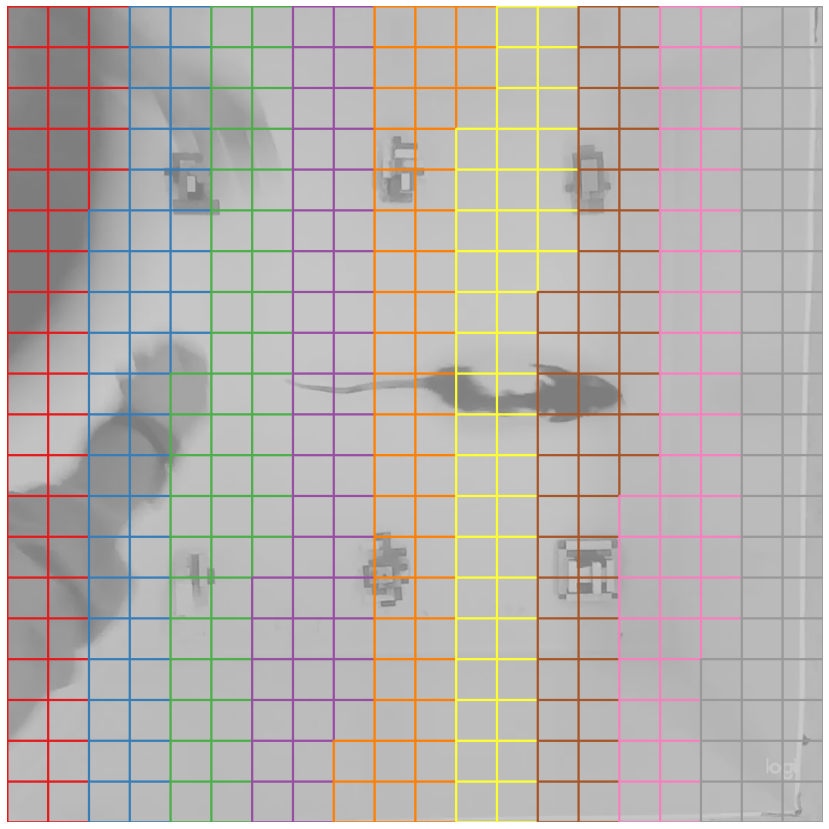

In [8]:
#ALTERNATIVE: IF WE WANTED TO CREATE GRID SQUARES THAT ARE OF A EXACT SIZE, E.G., EACH SQUARE SHOULD BE 3CMX3CM LARGE, 
#THEN WE CAN USE THE bucket_grid_size_mm parameter.
grid_30mm, aspect_ratio = GeometryMixin().bucket_img_into_grid_square(img_size=(width, height), bucket_grid_size_mm=30, px_per_mm=px_per_mm)

img = GeometryMixin().view_shapes(shapes=list(grid_30mm.values()), bg_img=video_frm)
height, width, depth = img.shape
figsize = width / float(dpi), height / float(dpi)

plt.figure(figsize=figsize)
plt.axis('off')
plt.imshow(img)
plt.show()

In [9]:
# WE CALCULATE THE CUMULATIVE TIME THE ANIMAL SPENDS IN EACH GEOMETRY

#NOTE: IF ANY PART OF THE ANIMAL GEOMETRY IS INTERSECTION WITH ANY OF THE GRID SQUARES, IT WILL BE 
#INTERPRESTED AS INSIDE THAT GRID SQURE. 
time_data = GeometryMixin().cumsum_animal_geometries_grid(data=shapes, grid=grid, fps=fps, verbose=False)

SIMBA COMPLETE: Cumulative animal geometries in grid complete (elapsed time: 6.0058s) 	complete


In [10]:
#THIS RETURNS A 3D ARRAY, WHERE THE LAST 2D ARRAY CORRESPONDS WITH THE CUMULATIVE TIME THE ANIMAL HAS SPENT IN
#EACH GEOMETRY AT THE END OF THE VIDEO.

#EACH 2D ARRAY REPRESENTS THE CUMULATIVE TIME THE ANIMAL HAS SPENT IN EACH GEOMETRY UP UNTIL AND INCLUDING THAT FRMAE,
#AND THE ARRAY WILL BE LEN(VIDEO FRAMES) X VERTICAL SHAPES X HORIXONTAL SHAPES. 

time_data[-1]

array([[ 12.9       ,  23.46666667,  38.16666667,  29.83333333,
          7.53333333],
       [ 41.23333333,  62.3       ,  58.5       ,  52.93333333,
         12.23333333],
       [ 59.2       ,  72.43333333,  49.63333333,  51.5       ,
         16.46666667],
       [ 44.9       , 114.76666667, 101.66666667,  49.8       ,
         11.83333333],
       [ 17.1       ,  65.56666667,  49.16666667,  13.86666667,
          0.23333333]])

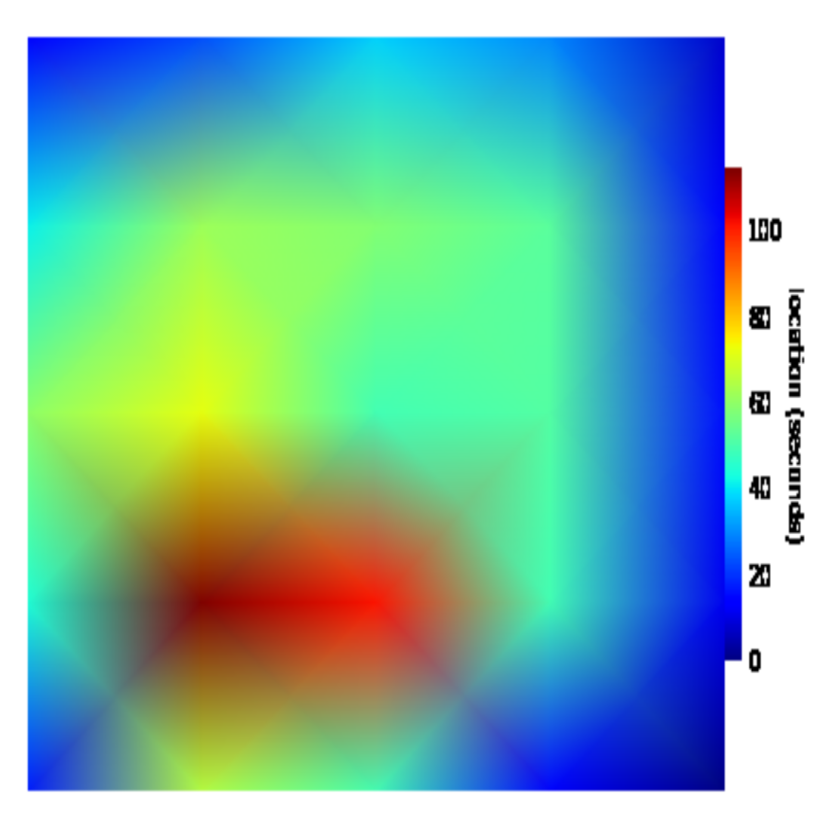

In [11]:
#TO PLOT A HEATMAP REPRESENTING THE GRID LOCATIONS OF THE ANIMAL IN THE VIDEO, USE 
# simba.mixins.plotting_mixin.PlottingMixin.make_location_heatmap_plot()

img = PlottingMixin().make_location_heatmap_plot(frm_data=time_data[-1],
                                                 max_scale=np.max(time_data[-1]),
                                                 palette='jet',
                                                 shading='gouraud',
                                                 img_size=(width, height),
                                                 aspect_ratio=None)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

height, width, depth = img.shape
figsize = width / float(dpi), height / float(dpi)

plt.figure(figsize=figsize)
plt.axis('off')
plt.imshow(img)
plt.show()